<a href="https://colab.research.google.com/github/raimirarara/maze_dqn/blob/main/maze_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sequential(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)
エピソード:0
step =  0
##########
#*  ######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  1
##########
#S* ######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  2
##########
#S* ######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  3
##########
#S *######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  4
##########
#S *######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  5
##########
#S *######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  6
##########
#S *######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  7
##########
#S *######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  8
##########
#S *######
#  #######
#   ######
##  #  ###
## 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:179: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


ストリーミング出力は最後の 5000 行に切り捨てられました。
##########
#S  ######
#  #######
#   ######
## *#  ###
##   G ###
##########
step =  46
##########
#S  ######
#  #######
#   ######
## *#  ###
##   G ###
##########
step =  47
##########
#S  ######
#  #######
#   ######
## *#  ###
##   G ###
##########
step =  48
##########
#S  ######
#  #######
#   ######
## *#  ###
##   G ###
##########
step =  49
##########
#S  ######
#  #######
#   ######
## *#  ###
##   G ###
##########
step =  50
##########
#S  ######
#  #######
#   ######
## *#  ###
##   G ###
##########
step =  51
##########
#S  ######
#  #######
#   ######
##  #  ###
## * G ###
##########
step =  52
##########
#S  ######
#  #######
#   ######
##  #  ###
##  *G ###
##########
迷路を解くのにかかったステップ数は53です
エピソード:40
step =  0
##########
#*  ######
#  #######
#   ######
##  #  ###
##   G ###
##########
step =  1
##########
#S  ######
#* #######
#   ######
##  #  ###
##   G ###
##########
step =  2
##########
#S  ######
#  #######
#*  ######
##  #  ###
##   

<function matplotlib.pyplot.show>

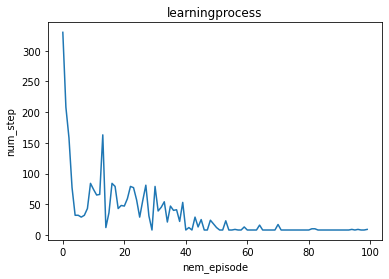

In [18]:
import random
import numpy as np
from matplotlib import pyplot as plt

# 迷路の読み込み
def readMaze():
  with open("maze.txt") as f:
    maze=f.readlines()
  maze=list(map(lambda x: list(x.strip()),maze))
  return maze

def printMaze(maze):
  for i,r in enumerate(maze):
    for j,c in enumerate(r):
      if i==row and j==col:
        print("*", end="")
      else:
        print(c, end="")
    print()


def get_s_next(s, a):
    global row
    global col
    global row_next
    global col_next
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        row_next = row - 1  # 上に移動するときは状態の数字が3小さくなる
        col_next = col
        if maze[row_next][col_next] == '#' or maze[row_next][col_next] == 'S': row_next += 1
    if next_direction == "right":
        col_next = col + 1  # 右に移動するときは状態の数字が1大きくなる
        row_next = row
        if maze[row_next][col_next]== '#' or maze[row_next][col_next] == 'S': col_next -= 1 
    if next_direction == "down":
        row_next = row + 1   # 下に移動するときは状態の数字が3大きくなる
        maze[row_next][col_next]
        if maze[row_next][col_next] == '#' or maze[row_next][col_next] == 'S': row_next -= 1
    if next_direction == "left":
        col_next = col - 1   # 左に移動するときは状態の数字が1小さくなる
        row_next = row_next
        if maze[row_next][col_next] == '#' or maze[row_next][col_next] == 'S': col_next += 1
        
    s_next = maze[row_next][col_next]

    return s_next


# namedtupleを生成
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

# 経験を保存するメモリクラスを定義します
class ReplayMemory:

    def __init__(self, CAPACITY): # 一回だけ読まれる
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

# エージェントが持つ脳となるクラスです、DQNを実行します
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # 選択しうる行動の数

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -----------------------------------------
        # 1. メモリサイズの確認
        # -----------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. ミニバッチの作成
        # -----------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                            if s is not None])

        # -----------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -----------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値（index=0）を出力します
        # detachでその値を取り出します
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 結合パラメータの更新
        # -----------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する（smooth_l1_lossはHuberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新

    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)は[torch.LongTensor of size 1]　を size 1x1 に変換します

        else:
            # 0,1, 2, 3の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0, 1, 2, 3の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action



maze = readMaze()
turn = 1
row = 1 # 現在の自分のいる列
col = 1 # 現在の自分のいる行
row_next = 1
col_next = 1

step_history = [] # Goalするのにかかったstep数を記録するリスト

# Q学習で迷路を解く
eta = 0.1  # 学習率
GAMMA = 0.9  # 時間割引率
episode = 1

MAX_STEPS = 500  # 1試行のstep数
NUM_EPISODES = 100  # 最大試行回数

num_states = 2
num_actions = 4

brain = Brain(num_states, num_actions)

for episode in range(NUM_EPISODES):  
    print("エピソード:" + str(episode))

    # Q学習で迷路を解き、移動した履歴と更新したQを求める
    global row
    global col
    global row_next
    global col_next
    global s_num
    global s_num_next
    row = 1 # スタート地点の座標を入力
    col = 1
    row_next = 1
    col_next = 1
    s = s_next = maze[row][col] #スタート地点
    s_num = np.array([row, col])
    state = torch.from_numpy(s_num).type(torch.FloatTensor)
    state = torch.unsqueeze(state, 0)
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    for step in range(MAX_STEPS):  # MAX_STEPSまでループ
        a = a_next = brain.decide_action(state, episode) # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a) # s_nextを更新
        s_num = np.array([row, col]) # s_numを更新
        state = torch.from_numpy(s_num).type(torch.FloatTensor) # s_numをテンソルに変換
        state = torch.unsqueeze(state, 0)
        s_num_next = np.array([ row_next, col_next])
        state_next = torch.from_numpy(s_num_next).type(torch.FloatTensor)
        state_next = torch.unsqueeze(state_next, 0)

          # 報酬を与え,　次の行動を求めます
        if s_next == 'G':
            a_next = np.nan
            state_next = None
            reward = torch.FloatTensor([1.0]) # 報酬を与える
        else:
            reward = torch.FloatTensor([0.0]) # 普段は報酬0
            a_next = brain.decide_action(state, episode)
            # 次の行動a_nextを求めます。


        # メモリに経験を追加
        brain.memory.push(state, a, state_next, reward)

            
        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく
        print("step = " , step)
        printMaze(maze)

        # Experience ReplayでQ関数を更新する
        brain.replay()

        # 終了判定
        if s_next == 'G':  # ゴール地点なら終了
            break
        else:
            row = row_next
            col = col_next
            s = s_next
            state = state_next
            s_num = s_num_next

    # print(s_a_history)
    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")
    step_history.append(len(s_a_history) - 1)
    # print(step_history)


# グラフを描画
plt.title("learningprocess")
plt.xlabel("num_episode")
plt.ylabel("num_step")
x = range(NUM_EPISODES)
y = step_history

plt.plot(x, y)
plt.show